In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime as dt

from tools import make_track, make_ER, kalman_filter, ols_regression, lasso_regression, ridge_regression
from hc_graph import hc_stock
sns.set()

<IPython.core.display.Javascript object>

Open console to check js libs were loaded in page


In [3]:
prices = pd.read_csv(r"financial_data/bnp_data.csv", index_col=0, parse_dates=True, dayfirst=True)[['BNPIFEU','BNPIFIT',
                            'BNPIFGE', 'BNPIFFR', 'BNPIFSP']]

prices_all = pd.read_csv(r"financial_data/bnp_data.csv", index_col=0, parse_dates=True, dayfirst=True)[['BNPIFEU',
                            'BNPIFUS', 'BNPIFJP', 'BNPIFCN', 'BNPIFFR', 'BNPIFGE', 'BNPIFGB', 'BNPIFCH', 'BNPIFKR',
                            'BNPIFUSC', 'BNPIFBR', 'BNPIFAU', 'BNPIFHK', 'BNPIFTW', 'BNPIFSG', 'BNPIFIT', 'BNPIFSP',
                            'BNPIFSW', 'BNPIFNE', 'BNPIFRU', 'BNPIFEM', 'BNPIFJT', 'BPFXEUR1', 'BPFXGBP1', 'BPFXCHF1',
                            'BPFXJPY1', 'BPFXAUD1', 'BPFXNZD1', 'BPFXNOK1', 'BPFXSEK1', 'BPFXCAD1', 'BPFXCZK1',
                            'BPFXPLN1', 'BPFXHUF1', 'BPFXTRY1', 'BPFXZAR1', 'BPFXSGD1', 'BPFXMXN1', 'BPFXINR1',
                            'BPFXKRW1', 'BPFXPHP1', 'BPFXTWD1', 'BPFXBRL1', 'BPFXCLP1', 'BPFXCOP1']]

returns = prices.resample("7D").first().pct_change().dropna()
returns_all = prices_all.resample("7D").first().pct_change().dropna()

In [4]:
sx5e = returns[["BNPIFEU"]]
bch = returns.drop("BNPIFEU", axis=1)
bch_all = returns_all.drop("BNPIFEU", axis=1)

size = 52
freq = 4


In [5]:
df_weight = ols_regression(sx5e, bch, size, freq)
df_weight_all = ols_regression(sx5e, bch_all, size, freq)

prices_for_track = prices.loc[df_weight.index[0]:].drop("BNPIFEU", axis=1)
prices_for_track_all = prices_all.loc[df_weight_all.index[0]:].drop("BNPIFEU", axis=1)

replication = make_track(prices_for_track, df_weight)
replication_all = make_track(prices_for_track_all, df_weight_all)

df_res = prices.loc[replication.index][["BNPIFEU"]]
df_res["OLS"] = replication
df_res["OLS all"] = replication_all

In [6]:
df_weight_ridge = ridge_regression(sx5e, bch, size, freq, l=1e-3)
df_weight_ridge_all = ridge_regression(sx5e, bch_all, size, freq, l=1e-3)

replication_ridge = make_track(prices_for_track, df_weight_ridge)
replication_ridge_all = make_track(prices_for_track_all, df_weight_ridge_all)

df_res["Ridge"] = replication_ridge
df_res["Ridge all"] = replication_ridge_all

In [7]:
df_weight_lasso = lasso_regression(sx5e, bch, size, freq, l=5e-5)
df_weight_lasso_all = lasso_regression(sx5e, bch_all, size, freq, l=5e-5)

replication_lasso = make_track(prices_for_track, df_weight_lasso)
replication_lasso_all = make_track(prices_for_track_all, df_weight_lasso_all)

df_res["Lasso"] = replication_lasso
df_res["Lasso all"] = replication_lasso_all

In [8]:
df_weight_kalman = kalman_filter(sx5e, bch, freq, sigma_weight=0.5, sigma_return=0.1)
df_weight_kalman_all = kalman_filter(sx5e, bch_all, freq, sigma_weight=0.5, sigma_return=0.1)

prices_for_track_kalman = prices.loc[df_weight_kalman.index[0]:].drop("BNPIFEU", axis=1)
prices_for_track_all_kalman = prices_all.loc[df_weight_kalman_all.index[0]:].drop("BNPIFEU", axis=1)

replication_kalman = make_track(prices_for_track_kalman, df_weight_kalman).loc[df_weight.index[0]:]
replication_kalman_all = make_track(prices_for_track_all_kalman, df_weight_kalman_all).loc[df_weight.index[0]:]

df_res["Kalman"] = replication_kalman
df_res["Kalman all"] = replication_kalman_all

In [9]:
df_res = df_res / df_res.iloc[0]

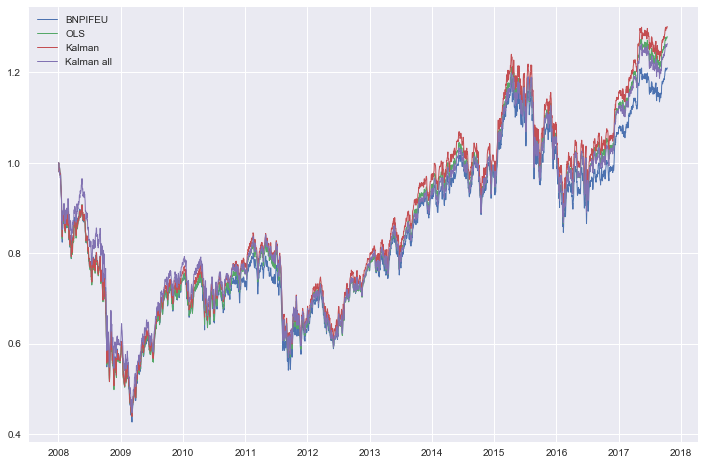

In [10]:
df_res[['BNPIFEU', 'OLS', 'Kalman', 'Kalman all']].plot(figsize=(12,8),linewidth=1)

In [11]:
g = hc_stock(df_res)
g.plot()

In [12]:
df_res.pct_change().corr(method="pearson")

,BNPIFEU,OLS,OLS all,Ridge,Ridge all,Lasso,Lasso all,Kalman,Kalman all
BNPIFEU,1.000000,0.987041,0.934444,0.984779,0.976029,0.986774,0.985996,0.987078,0.980667
OLS,0.987041,1.000000,0.948651,0.996967,0.986573,0.999829,0.998857,0.999252,0.991653
OLS all,0.934444,0.948651,1.000000,0.944768,0.961260,0.949037,0.951233,0.946107,0.947609
Ridge,0.984779,0.996967,0.944768,1.000000,0.986482,0.997220,0.996235,0.997254,0.990435
Ridge all,0.976029,0.986573,0.961260,0.986482,1.000000,0.986626,0.988879,0.986211,0.990181
Lasso,0.986774,0.999829,0.949037,0.997220,0.986626,1.000000,0.998961,0.999092,0.991434
Lasso all,0.985996,0.998857,0.951233,0.996235,0.988879,0.998961,1.000000,0.998104,0.992743
Kalman,0.987078,0.999252,0.946107,0.997254,0.986211,0.999092,0.998104,1.000000,0.992411
Kalman all,0.980667,0.991653,0.947609,0.990435,0.990181,0.991434,0.992743,0.992411,1.000000


In [13]:
df_res.pct_change().corr(method="kendall")

,BNPIFEU,OLS,OLS all,Ridge,Ridge all,Lasso,Lasso all,Kalman,Kalman all
BNPIFEU,1.000000,0.912106,0.796921,0.900079,0.869379,0.911170,0.908861,0.912962,0.893892
OLS,0.912106,1.000000,0.814428,0.952201,0.894692,0.991581,0.977149,0.986258,0.929956
OLS all,0.796921,0.814428,1.000000,0.809107,0.849096,0.814354,0.818127,0.814291,0.828527
Ridge,0.900079,0.952201,0.809107,1.000000,0.894057,0.950882,0.944772,0.954255,0.918562
Ridge all,0.869379,0.894692,0.849096,0.894057,1.000000,0.893944,0.901385,0.895181,0.911634
Lasso,0.911170,0.991581,0.814354,0.950882,0.893944,1.000000,0.980387,0.982783,0.929211
Lasso all,0.908861,0.977149,0.818127,0.944772,0.901385,0.980387,1.000000,0.972722,0.932229
Kalman,0.912962,0.986258,0.814291,0.954255,0.895181,0.982783,0.972722,1.000000,0.931856
Kalman all,0.893892,0.929956,0.828527,0.918562,0.911634,0.929211,0.932229,0.931856,1.000000


In [14]:
returns_track = df_res.pct_change().dropna()
feu = returns_track['BNPIFEU']
returns_track = returns_track.drop('BNPIFEU', axis=1)
df = pd.DataFrame()
df['Tracking error'] = (returns_track.T - feu.values).std(axis=1)
df['R-squared'] = 1 - (returns_track.T - feu.values).var(axis=1) / feu.values.var()
df

,Tracking error,R-squared
OLS,0.002462,0.973566
OLS all,0.005580,0.864168
Ridge,0.002951,0.962016
Ridge all,0.003304,0.952392
Lasso,0.002586,0.970833
Lasso all,0.002685,0.968551
Kalman,0.002455,0.973705
Kalman all,0.002972,0.961479


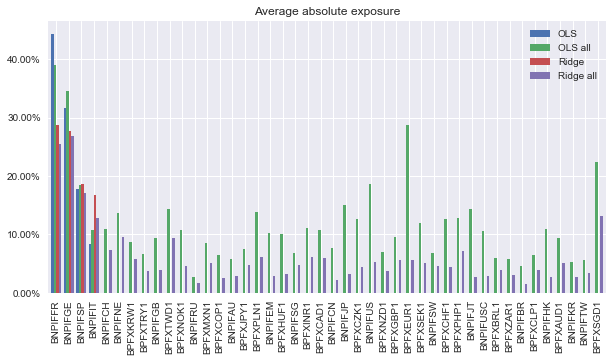

In [15]:
weight = pd.DataFrame(data={'Lasso all': np.abs(df_weight_lasso_all).mean(axis=0).sort_values(ascending=False)})
weight.insert(0, 'OLS', np.abs(df_weight).mean(axis=0))
weight.insert(1, 'OLS all', np.abs(df_weight_all).mean(axis=0))
weight.insert(2, 'Lasso', np.abs(df_weight_lasso).mean(axis=0))
weight['Ridge'] = np.abs(df_weight_ridge).mean(axis=0)
weight['Ridge all'] = np.abs(df_weight_ridge_all).mean(axis=0)
weight['Kalman'] = np.abs(df_weight_kalman).mean(axis=0)
weight['Kalman all'] = np.abs(df_weight_kalman_all).mean(axis=0)
ax = weight[['OLS', 'OLS all', 'Ridge', 'Ridge all']].plot(kind='bar', title='Average absolute exposure', figsize=(10, 5), width=0.8)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
plt.show()

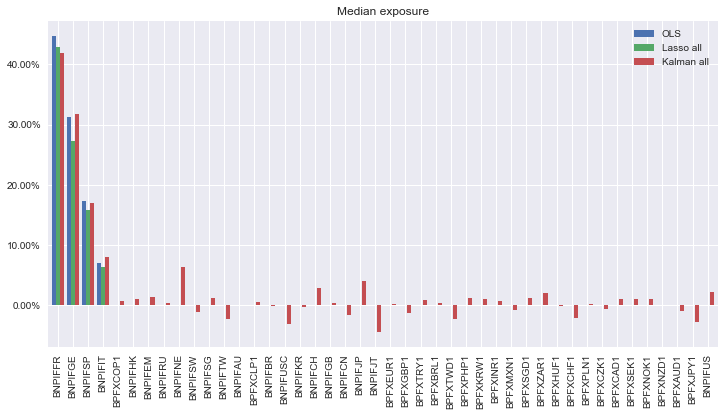

In [16]:
weight = pd.DataFrame(data={'Lasso all': (df_weight_lasso_all).median(axis=0).sort_values(ascending=False)})
weight.insert(0, 'OLS', (df_weight).median(axis=0))
weight.insert(1, 'OLS all', (df_weight_all).median(axis=0))
weight.insert(2, 'Lasso', (df_weight_lasso).median(axis=0))
weight['Ridge'] = (df_weight_ridge).median(axis=0)
weight['Ridge all'] = (df_weight_ridge_all).median(axis=0)
weight['Kalman'] = (df_weight_kalman).median(axis=0)
weight['Kalman all'] = (df_weight_kalman_all).median(axis=0)
ax = weight[['OLS', 'Lasso all', 'Kalman all']].plot(kind='bar', title='Median exposure', figsize=(12, 6), width=0.8)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
plt.show()

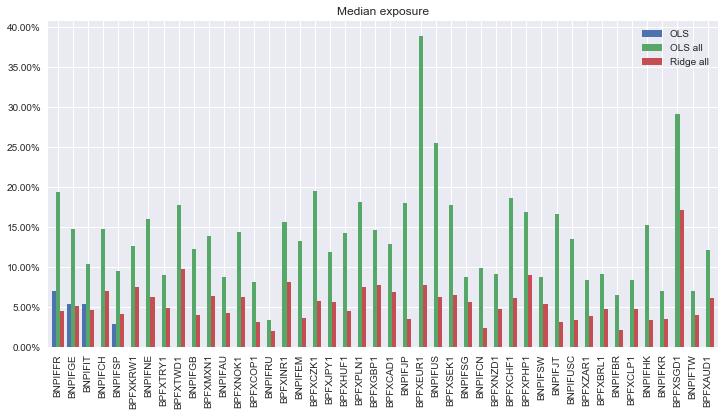

In [17]:
weight = pd.DataFrame(data={'Lasso all': (df_weight_lasso_all).std(axis=0).sort_values(ascending=False)})
weight.insert(0, 'OLS', (df_weight).std(axis=0))
weight.insert(1, 'OLS all', (df_weight_all).std(axis=0))
weight.insert(2, 'Lasso', (df_weight_lasso).std(axis=0))
weight['Ridge'] = (df_weight_ridge).std(axis=0)
weight['Ridge all'] = (df_weight_ridge_all).std(axis=0)
weight['Kalman'] = (df_weight_kalman).std(axis=0)
weight['Kalman all'] = (df_weight_kalman_all).std(axis=0)
ax = weight[['OLS', 'OLS all', 'Ridge all']].plot(kind='bar', title='Median exposure', figsize=(12, 6), width=0.8)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
plt.show()

# Lasso lambda impact

In [18]:
df_l = df_res[['BNPIFEU']].copy()
weights_l = {}

In [19]:
for l in [3e-3, 2e-3, 1e-3, 9e-4, 8e-4, 7e-4, 6e-4, 5e-4, 2e-4, 1e-4, 5e-5, 2e-5, 1e-5, 5e-6, 2e-6, 1e-6, 5e-7, 2e-7, 1e-7, 5e-8, 2e-8, 1e-8]:
    weight_lasso = lasso_regression(sx5e, bch_all, size, freq, l=l)
    replication_lasso = make_track(prices_for_track_all, weight_lasso)
    df_l[str(l)] = replication_lasso
    weights_l[str(l)] = weight_lasso

c:\program files (x86)\python36-32\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [20]:
df_l = df_l / df_l.iloc[0]

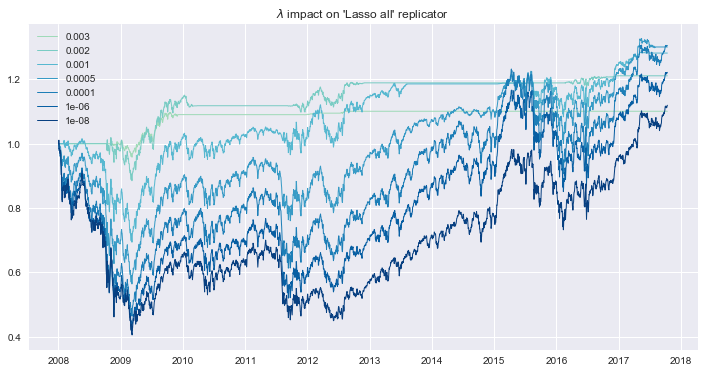

In [21]:
colors = plt.cm.GnBu(np.linspace(0.4, 1, 7))
ax = df_l[['0.003', '0.002', '0.001', '0.0005', '0.0001', '1e-06', '1e-08']].plot(figsize=(12, 6), linewidth=1, color=colors, title="$\lambda$ impact on 'Lasso all' replicator")

In [22]:
returns_track = df_l.pct_change().dropna()
corr = returns_track.corr(method="pearson")['BNPIFEU'].drop('BNPIFEU')
feu = returns_track['BNPIFEU']
returns_track = returns_track.drop('BNPIFEU', axis=1)
df = pd.DataFrame()
df['Tracking error'] = (returns_track.T - feu.values).std(axis=1)
df['R-squared'] = 1 - (returns_track.T - feu.values).var(axis=1) / feu.values.var()
df['Correlation'] = corr.T
df.index = [np.float(x) for x in corr.index.values]

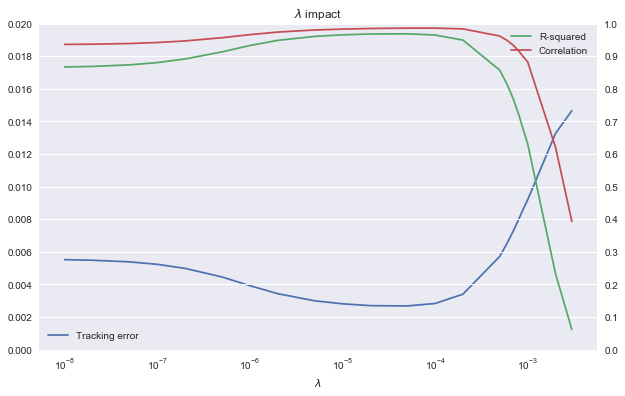

In [23]:
ax=df.plot(figsize=(10, 6), logx=True, secondary_y=["R-squared", "Correlation"], title="$\lambda$ impact", ylim=[0.00,0.020])
ax.legend(loc=3)
ax.set_xlabel('$\lambda$')
plt.legend(loc=1)
plt.ylim(0,1)
plt.locator_params(axis='y', nbins=10)
ax.locator_params(axis='y', nbins=10)

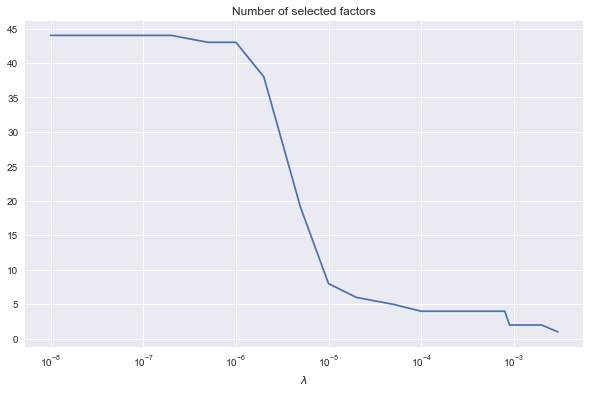

In [24]:
weights = {}
for l in weights_l.keys():
    df_weights = weights_l[l]
    n = len(df_weights.index)
    weights[l] = np.sum((np.abs(df_weights).mean() > 0.02))
w = pd.DataFrame.from_dict(weights, orient='index')
w.index = [np.float(x) for x in w.index.values]
ax = w[0].sort_index().plot(logx=True, figsize=(10, 6), title="Number of selected factors", label=False)
ax.set_xlabel('$\lambda$')
ax.locator_params(axis='y', nbins=10)

# Ridge gamma impact

In [25]:
df_r = df_res[['BNPIFEU']].copy()
weights_r = {}

In [26]:
for l in [100, 50, 20, 10, 5, 2, 1, 7e-1, 5e-1, 2e-1, 1e-1, 7e-2, 5e-2, 4e-2, 3e-2, 2e-2, 1e-2, 9e-3, 8e-3, 7e-3, 6e-3, 5e-3, 2e-3, 1e-3, 5e-4, 2e-4, 1e-4, 5e-5, 2e-5, 1e-5, 5e-6, 2e-6, 1e-6, 5e-7, 2e-7, 1e-7]:
    weight_ridge = ridge_regression(sx5e, bch_all, size, freq, l=l)
    replication_ridge = make_track(prices_for_track_all, weight_ridge)
    df_r[str(l)] = replication_ridge
    weights_r[str(l)] = weight_ridge

In [27]:
df_r = df_r / df_r.iloc[0]

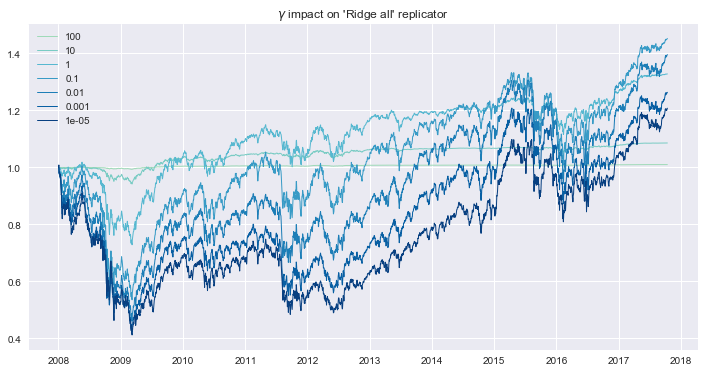

In [28]:
colors = plt.cm.GnBu(np.linspace(0.4, 1, 7))
ax = df_r[['100', '10', '1', '0.1', '0.01', '0.001', '1e-05']].plot(figsize=(12, 6), linewidth=1, color=colors, title="$\gamma$ impact on 'Ridge all' replicator")

In [29]:
returns_track = df_r.pct_change().dropna()
corr = returns_track.corr(method="pearson")['BNPIFEU'].drop('BNPIFEU')
feu = returns_track['BNPIFEU']
returns_track = returns_track.drop('BNPIFEU', axis=1)
df = pd.DataFrame()
df['Tracking error'] = (returns_track.T - feu.values).std(axis=1)
df['R-squared'] = 1 - (returns_track.T - feu.values).var(axis=1) / feu.values.var()
df['Correlation'] = corr.T
df.index = [np.float(x) for x in corr.index.values]

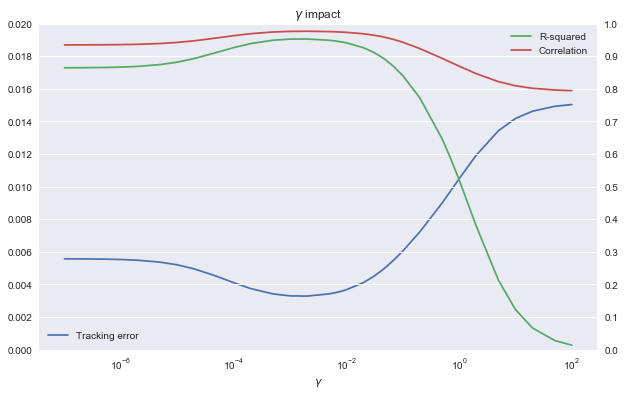

In [30]:
ax=df.plot(figsize=(10, 6), logx=True, secondary_y=["R-squared", "Correlation"], title="$\gamma$ impact", ylim=[0.00,0.020])
ax.legend(loc=3)
ax.set_xlabel('$\gamma$')
plt.legend(loc=1)
plt.ylim(0,1)
plt.locator_params(axis='y', nbins=10)
ax.locator_params(axis='y', nbins=10)

Text(0.5,0,'$\\gamma$')

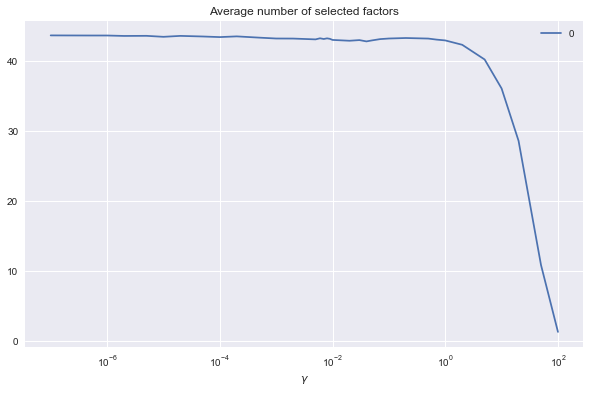

In [31]:
weights = {}
for l in weights_r.keys():
    df_weights = weights_r[l]
    n = len(df_weights.index)
    weights[l] = np.sum((np.abs(df_weights) > 0.001).sum()) / n
w = pd.DataFrame.from_dict(weights, orient='index')
w.index = [np.float(x) for x in w.index.values]
ax = w.sort_index().plot(logx=True, figsize=(10, 6), title="Average number of selected factors")
ax.set_xlabel('$\gamma$')

# Ridge Noise impact

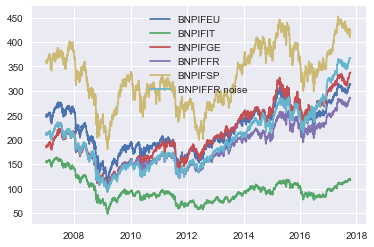

In [32]:
prices_noise = prices.copy()
FFR_noise = [prices_noise['BNPIFFR'].iloc[0]]
for i in range(len(prices_noise.index)-1):
    if (i//(5*size))%2==0: a = 0.0001
    else: a = 0.005
    FFR_noise.append(FFR_noise[i] * (prices_noise['BNPIFFR'].iloc[i+1] / prices_noise['BNPIFFR'].iloc[i] + a * np.random.normal()))
prices_noise['BNPIFFR noise'] = FFR_noise
prices_noise.plot()
returns_noise = prices_noise.resample("7D").first().pct_change().dropna()

In [33]:
sx5e = returns_noise[["BNPIFEU"]]
bch = returns_noise.drop("BNPIFEU", axis=1)

size = 52
freq = 52

In [34]:
df_weight_noise = ols_regression(sx5e, bch, size, freq)

prices_for_track = prices_noise.loc[df_weight.index[0]:].drop("BNPIFEU", axis=1)

replication_noise = make_track(prices_for_track, df_weight_noise)
df_res["OLS noise"] = replication_noise

In [35]:
df_weight_ridge_noise = ridge_regression(sx5e, bch, size, freq, l=1e-3)

replication_ridge_noise = make_track(prices_for_track, df_weight_ridge_noise)
df_res["Ridge noise"] = replication_ridge_noise

In [36]:
df_weight_kalman_noise = kalman_filter(sx5e, bch, freq, sigma_weight=0.05, sigma_return=0.005)

replication_kalman_noise = make_track(prices_for_track, df_weight_kalman_noise)
df_res["Kalman noise"] = replication_kalman_noise

In [37]:
df_res = df_res / df_res.iloc[0]

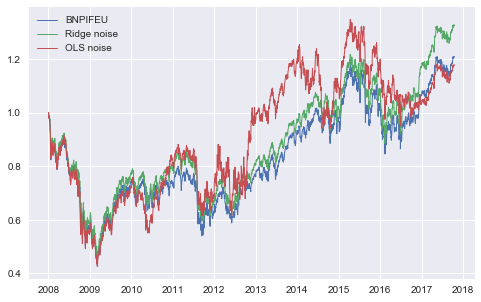

In [38]:
df_res[['BNPIFEU', 'Ridge noise', 'OLS noise']].plot(figsize=(8,5),linewidth=1)

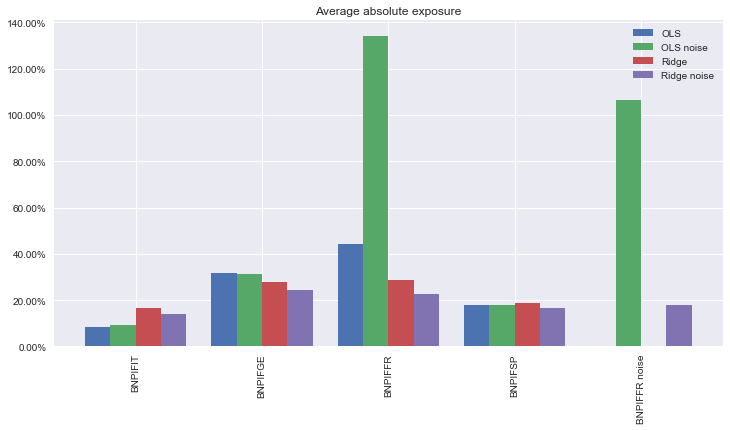

In [39]:
weight_noise = pd.DataFrame(data={'OLS noise': np.abs(df_weight_noise).mean(axis=0)})
weight_noise.insert(0, 'OLS', np.abs(df_weight).mean(axis=0))
weight_noise['Ridge'] = np.abs(df_weight_ridge).mean(axis=0)
weight_noise['Ridge noise'] = np.abs(df_weight_ridge_noise).mean(axis=0)
ax = weight_noise.plot(kind='bar', title='Average absolute exposure', figsize=(12, 6), width=0.8)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
plt.show()

[Text(0,0,'2008'),
 Text(0,0,'2009'),
 Text(0,0,'2010'),
 Text(0,0,'2011'),
 Text(0,0,'2012'),
 Text(0,0,'2013'),
 Text(0,0,'2014'),
 Text(0,0,'2015'),
 Text(0,0,'2016'),
 Text(0,0,'2017')]

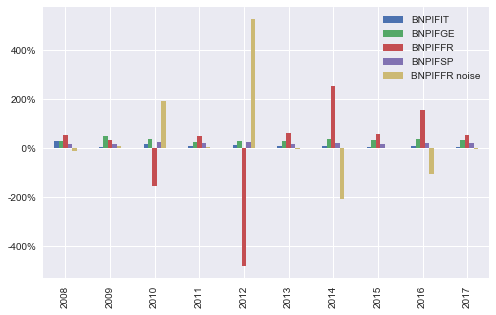

In [40]:
ax = df_weight_noise.plot(kind='bar', figsize=(8,5))
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
vals = ax.get_xticks()
ax.set_xticklabels([2008 + x for x in vals])

[Text(0,0,'2008'),
 Text(0,0,'2009'),
 Text(0,0,'2010'),
 Text(0,0,'2011'),
 Text(0,0,'2012'),
 Text(0,0,'2013'),
 Text(0,0,'2014'),
 Text(0,0,'2015'),
 Text(0,0,'2016'),
 Text(0,0,'2017')]

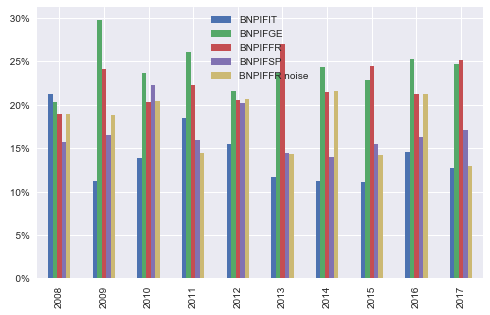

In [41]:
ax = df_weight_ridge_noise.plot(kind='bar', figsize=(8,5))
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
vals = ax.get_xticks()
ax.set_xticklabels([2008 + x for x in vals])

In [42]:
df_weight_ridge_noise

,BNPIFIT,BNPIFGE,BNPIFFR,BNPIFSP,BNPIFFR noise
2008-01-02,0.212838,0.202562,0.188903,0.157218,0.189063
2008-12-31,0.111967,0.297940,0.240622,0.164587,0.188593
2009-12-30,0.138301,0.236705,0.203381,0.222382,0.203875
2010-12-29,0.184940,0.260617,0.223077,0.159619,0.143963
2011-12-28,0.154918,0.216153,0.205145,0.201836,0.206447
2012-12-26,0.116519,0.236616,0.270364,0.144381,0.143017
2013-12-25,0.112461,0.243045,0.214994,0.139943,0.215198
2014-12-24,0.111371,0.228734,0.244562,0.155133,0.141975
2015-12-23,0.145676,0.252328,0.211842,0.162437,0.211793
2016-12-21,0.127565,0.246599,0.251465,0.170263,0.129851



# Kalman Filter parameters

In [43]:
df_k = prices.loc[replication.index][["BNPIFEU"]]
df_k = df_k / df_k.iloc[0]

In [44]:
nsteps = 20
sigma_return_list = np.linspace(0.05, 0, nsteps, endpoint=False)
sigma_weight_list = np.linspace(.5, 0, nsteps, endpoint=False)
te_2 = pd.DataFrame(index=sigma_weight_list)
r2_2 = pd.DataFrame(index=sigma_weight_list)
correl_2 = pd.DataFrame(index=sigma_weight_list)

for sigma_weight in sigma_weight_list:
    for sigma_return in sigma_return_list:
        df_weight_kalman = kalman_filter(sx5e, bch, freq, sigma_weight=sigma_weight, sigma_return=sigma_return)
        prices_for_track_kalman = prices.loc[df_weight_kalman.index[0]:].drop("BNPIFEU", axis=1)
        replication_kalman = make_track(prices_for_track_kalman, df_weight_kalman).loc[df_weight.index[0]:]
        df_k['Kalman'] = replication_kalman
        
        returns_track = df_k.pct_change().dropna()
        corr = returns_track.corr(method="pearson")['BNPIFEU'].drop('BNPIFEU').iloc[0]
        feu = returns_track['BNPIFEU']
        returns_track = returns_track.drop('BNPIFEU', axis=1)
        
        te_2.loc[sigma_weight,sigma_return] = (returns_track.T - feu.values).std(axis=1).iloc[0]
        r2_2.loc[sigma_weight,sigma_return] = 1 - ((returns_track.T - feu.values).var(axis=1) / feu.values.var()).iloc[0]
        correl_2.loc[sigma_weight,sigma_return] = corr

te_2 = te_2.reindex_axis(sorted(te_2.columns), axis=1).sort_index(ascending=False)
r2_2 = r2_2.reindex_axis(sorted(r2_2.columns), axis=1).sort_index(ascending=False)
correl_2 = correl_2.reindex_axis(sorted(correl_2.columns), axis=1).sort_index(ascending=False)

c:\program files (x86)\python36-32\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
c:\program files (x86)\python36-32\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
c:\program files (x86)\python36-32\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.


Text(34,0.5,'$\\sigma_\\eta$')

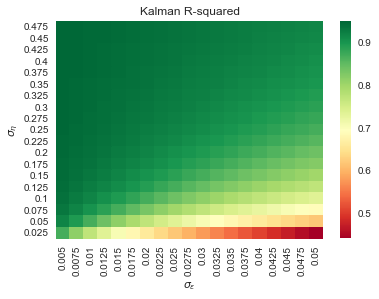

In [45]:
ax = sns.heatmap(r2_2.iloc[1:,1:], cmap='RdYlGn')
ax.set_title('Kalman R-squared')
ax.set_xlabel("$\sigma_\epsilon$")
ax.set_ylabel("$\sigma_\eta$")

Text(34,0.5,'$\\sigma_\\eta$')

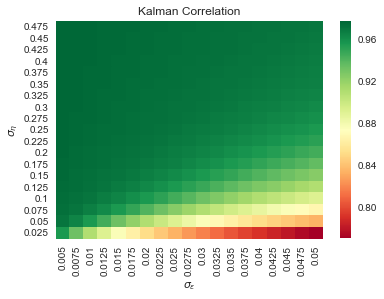

In [46]:
ax = sns.heatmap(correl_2.iloc[1:,1:], cmap='RdYlGn')
ax.set_title('Kalman Correlation')
ax.set_xlabel("$\sigma_\epsilon$")
ax.set_ylabel("$\sigma_\eta$")

Text(34,0.5,'$\\sigma_\\eta$')

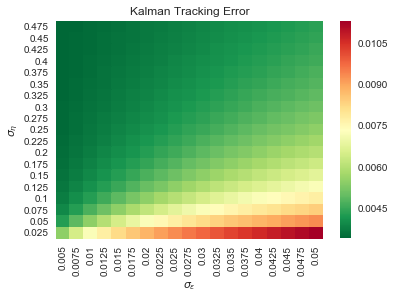

In [47]:
ax = sns.heatmap(te_2.iloc[1:,1:], cmap='RdYlGn_r')
ax.set_title('Kalman Tracking Error')
ax.set_xlabel("$\sigma_\epsilon$")
ax.set_ylabel("$\sigma_\eta$")

In [48]:
nsteps = 20
sigma_return_list = np.linspace(0.05, 0, nsteps, endpoint=False)
sigma_weight_list = np.linspace(.5, 0, nsteps, endpoint=False)
te_2_all = pd.DataFrame(index=sigma_weight_list)
r2_2_all = pd.DataFrame(index=sigma_weight_list)
correl_2_all = pd.DataFrame(index=sigma_weight_list)

for sigma_weight in sigma_weight_list:
    for sigma_return in sigma_return_list:
        df_weight_kalman = kalman_filter(sx5e, bch_all, freq, sigma_weight=sigma_weight, sigma_return=sigma_return)
        prices_for_track_kalman = prices_all.loc[df_weight_kalman.index[0]:].drop("BNPIFEU", axis=1)
        replication_kalman = make_track(prices_for_track_kalman, df_weight_kalman).loc[df_weight.index[0]:]
        df_k['Kalman'] = replication_kalman
        
        returns_track = df_k.pct_change().dropna()
        corr = returns_track.corr(method="pearson")['BNPIFEU'].drop('BNPIFEU').iloc[0]
        feu = returns_track['BNPIFEU']
        returns_track = returns_track.drop('BNPIFEU', axis=1)
        
        te_2_all.loc[sigma_weight,sigma_return] = (returns_track.T - feu.values).std(axis=1).iloc[0]
        r2_2_all.loc[sigma_weight,sigma_return] = 1 - ((returns_track.T - feu.values).var(axis=1) / feu.values.var()).iloc[0]
        correl_2_all.loc[sigma_weight,sigma_return] = corr

te_2_all = te_2_all.reindex_axis(sorted(te_2_all.columns), axis=1).sort_index(ascending=False)
r2_2_all = r2_2_all.reindex_axis(sorted(r2_2_all.columns), axis=1).sort_index(ascending=False)
correl_2_all = correl_2_all.reindex_axis(sorted(correl_2_all.columns), axis=1).sort_index(ascending=False)

c:\program files (x86)\python36-32\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
c:\program files (x86)\python36-32\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
c:\program files (x86)\python36-32\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.


Text(34,0.5,'$\\sigma_\\eta$')

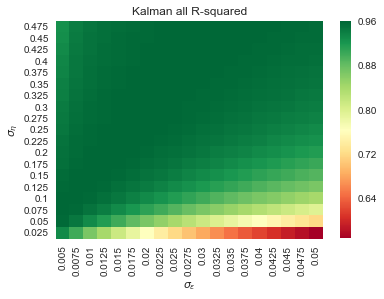

In [49]:
ax = sns.heatmap(r2_2_all.iloc[1:,1:], cmap='RdYlGn')
ax.set_title('Kalman all R-squared')
ax.set_xlabel("$\sigma_\epsilon$")
ax.set_ylabel("$\sigma_\eta$")

Text(34,0.5,'$\\sigma_\\eta$')

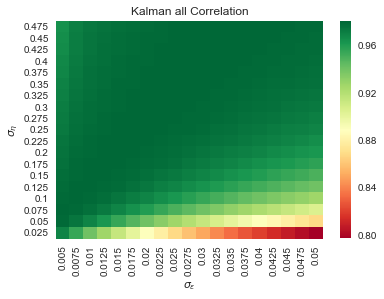

In [50]:
ax = sns.heatmap(correl_2_all.iloc[1:,1:], cmap='RdYlGn')
ax.set_title('Kalman all Correlation')
ax.set_xlabel("$\sigma_\epsilon$")
ax.set_ylabel("$\sigma_\eta$")

Text(34,0.5,'$\\sigma_\\eta$')

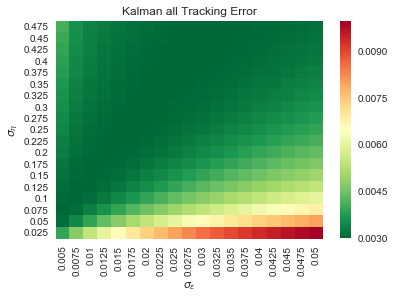

In [51]:
ax = sns.heatmap(te_2_all.iloc[1:,1:], cmap='RdYlGn_r')
ax.set_title('Kalman all Tracking Error')
ax.set_xlabel("$\sigma_\epsilon$")
ax.set_ylabel("$\sigma_\eta$")


# Impact of Lookback period and rebalancing frequency

In [52]:
df_o = prices.loc[replication.index][["BNPIFEU"]]

In [53]:
prices_lg = pd.read_csv(r"financial_data/bnp_data_long_term.csv", index_col=0, parse_dates=True, dayfirst=True)[['BNPIFEU','BNPIFIT',
                            'BNPIFGE', 'BNPIFFR', 'BNPIFSP']]


In [54]:
returns_lg = prices_lg.resample("7D").first().pct_change().dropna()
prices_for_track_lg = prices_lg.iloc[-2570:].drop("BNPIFEU", axis=1)


lookback_list = range(5, 250, 5)
freq_list = range(2, 105, 2)

te_ols = pd.DataFrame(index=freq_list)
r2_ols = pd.DataFrame(index=freq_list)
correl_ols = pd.DataFrame(index=freq_list)

for lookback in lookback_list:
    sx5e_lg = returns_lg[["BNPIFEU"]].iloc[-513-lookback:]
    bch_lg = returns_lg.drop("BNPIFEU", axis=1).iloc[-513-lookback:]
    
    for frequency in freq_list:
        
        df_weight_ols = ols_regression(sx5e_lg, bch_lg, lookback, frequency)
        replication_ols = make_track(prices_for_track_lg, df_weight_ols)
        df_o['OLS'] = replication_ols
        
        returns_track = df_o.pct_change().dropna()
        corr = returns_track.corr(method="pearson")['BNPIFEU'].drop('BNPIFEU').iloc[0]
        feu = returns_track['BNPIFEU']
        returns_track = returns_track.drop('BNPIFEU', axis=1)
        
        te_ols.loc[frequency, lookback] = (returns_track.T - feu.values).std(axis=1).iloc[0]
        r2_ols.loc[frequency, lookback] = 1 - ((returns_track.T - feu.values).var(axis=1) / feu.values.var()).iloc[0]
        correl_ols.loc[frequency, lookback] = corr
        
te_ols = te_ols.reindex_axis(sorted(te_ols.columns), axis=1).sort_index(ascending=False)
r2_ols = r2_ols.reindex_axis(sorted(r2_ols.columns), axis=1).sort_index(ascending=False)
correl_ols = correl_ols.reindex_axis(sorted(correl_ols.columns), axis=1).sort_index(ascending=False)

c:\program files (x86)\python36-32\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
c:\program files (x86)\python36-32\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
c:\program files (x86)\python36-32\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.


Text(124,0.5,'Rebalancing Frequency (in weeks)')

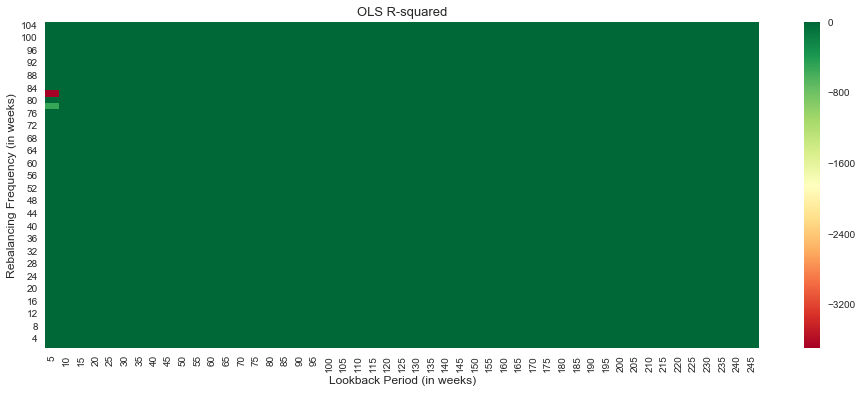

In [55]:
fig, ax = plt.subplots(figsize=(16,6))
sns.heatmap(r2_ols.loc[:,:].sort_index(ascending=False), ax=ax, cmap='RdYlGn')
ax.set_title('OLS R-squared', fontsize=13)
ax.set_xlabel("Lookback Period (in weeks)", fontsize=12)
ax.set_ylabel("Rebalancing Frequency (in weeks)", fontsize=12)

In [56]:
prices_lg = pd.read_csv(r"financial_data/bnp_data_long_term.csv", index_col=0, parse_dates=True, dayfirst=True)[['BNPIFEU',
                            'BNPIFUS', 'BNPIFJP', 'BNPIFCN', 'BNPIFFR', 'BNPIFGE', 'BNPIFGB', 'BNPIFCH', 'BNPIFKR',
                            'BNPIFUSC', 'BNPIFBR', 'BNPIFAU', 'BNPIFHK', 'BNPIFTW', 'BNPIFSG', 'BNPIFIT', 'BNPIFSP',
                            'BNPIFSW', 'BNPIFNE', 'BNPIFRU', 'BNPIFEM', 'BNPIFJT', 'BPFXEUR1', 'BPFXGBP1', 'BPFXCHF1',
                            'BPFXJPY1', 'BPFXAUD1', 'BPFXNZD1', 'BPFXNOK1', 'BPFXSEK1', 'BPFXCAD1', 'BPFXCZK1',
                            'BPFXPLN1', 'BPFXHUF1', 'BPFXTRY1', 'BPFXZAR1', 'BPFXSGD1', 'BPFXMXN1', 'BPFXINR1',
                            'BPFXKRW1', 'BPFXPHP1', 'BPFXTWD1', 'BPFXBRL1', 'BPFXCLP1', 'BPFXCOP1']]

returns_lg = prices_lg.resample("7D").first().pct_change().dropna()
prices_for_track_lg = prices_lg.iloc[-2570:].drop("BNPIFEU", axis=1)


lookback_list = range(5, 250, 5)
freq_list = range(2, 105, 2)

te_ols_all = pd.DataFrame(index=freq_list)
r2_ols_all = pd.DataFrame(index=freq_list)
correl_ols_all = pd.DataFrame(index=freq_list)

for lookback in lookback_list:
    sx5e_lg = returns_lg[["BNPIFEU"]].iloc[-513-lookback:]
    bch_lg = returns_lg.drop("BNPIFEU", axis=1).iloc[-513-lookback:]
    
    for frequency in freq_list:
        
        df_weight_ols = ols_regression(sx5e_lg, bch_lg, lookback, frequency)
        replication_ols = make_track(prices_for_track_lg, df_weight_ols)
        df_o['OLS'] = replication_ols
        
        returns_track = df_o.pct_change().dropna()
        corr = returns_track.corr(method="pearson")['BNPIFEU'].drop('BNPIFEU').iloc[0]
        feu = returns_track['BNPIFEU']
        returns_track = returns_track.drop('BNPIFEU', axis=1)
        
        te_ols_all.loc[frequency, lookback] = (returns_track.T - feu.values).std(axis=1).iloc[0]
        r2_ols_all.loc[frequency, lookback] = 1 - ((returns_track.T - feu.values).var(axis=1) / feu.values.var()).iloc[0]
        correl_ols_all.loc[frequency, lookback] = corr
        
te_ols_all = te_ols_all.reindex_axis(sorted(te_ols_all.columns), axis=1).sort_index(ascending=False)
r2_ols_all = r2_ols_all.reindex_axis(sorted(r2_ols_all.columns), axis=1).sort_index(ascending=False)
correl_ols_all = correl_ols_all.reindex_axis(sorted(correl_ols_all.columns), axis=1).sort_index(ascending=False)

c:\program files (x86)\python36-32\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
c:\program files (x86)\python36-32\lib\site-packages\ipykernel_launcher.py:40: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
c:\program files (x86)\python36-32\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.


Text(124,0.5,'Rebalancing Frequency (in weeks)')

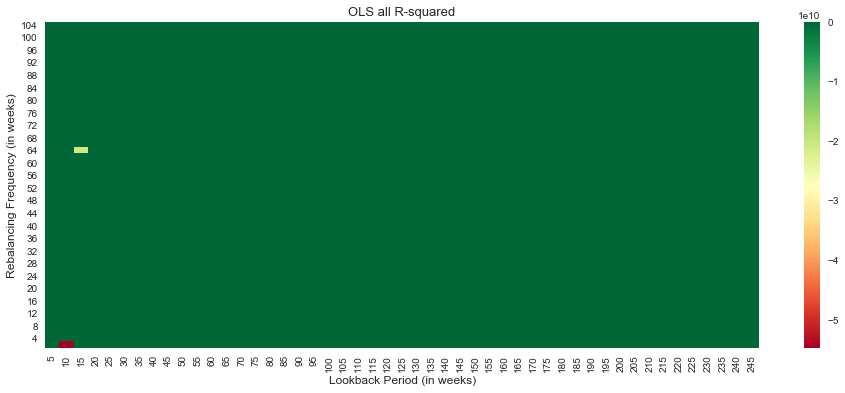

In [57]:
fig, ax = plt.subplots(figsize=(16,6))
sns.heatmap(r2_ols_all.loc[:,:].sort_index(ascending=False), ax=ax, cmap='RdYlGn')
ax.set_title('OLS all R-squared', fontsize=13)
ax.set_xlabel("Lookback Period (in weeks)", fontsize=12)
ax.set_ylabel("Rebalancing Frequency (in weeks)", fontsize=12)

In [58]:
df_r = prices.loc[replication.index][["BNPIFEU"]]

prices_lg = pd.read_csv(r"financial_data/bnp_data_long_term.csv", index_col=0, parse_dates=True, dayfirst=True)[['BNPIFEU','BNPIFIT',
                            'BNPIFGE', 'BNPIFFR', 'BNPIFSP']]

returns_lg = prices_lg.resample("7D").first().pct_change().dropna()
prices_for_track_lg = prices_lg.iloc[-2570:].drop("BNPIFEU", axis=1)


lookback_list = range(5, 250, 5)
freq_list = range(2, 105, 2)

te_ridge = pd.DataFrame(index=freq_list)
r2_ridge = pd.DataFrame(index=freq_list)
correl_ridge = pd.DataFrame(index=freq_list)

for lookback in lookback_list:
    sx5e_lg = returns_lg[["BNPIFEU"]].iloc[-513-lookback:]
    bch_lg = returns_lg.drop("BNPIFEU", axis=1).iloc[-513-lookback:]
    
    for frequency in freq_list:
        
        df_weight_ridge = ridge_regression(sx5e_lg, bch_lg, lookback, frequency, l=1e-3)
        replication_ridge = make_track(prices_for_track_lg, df_weight_ridge)
        df_r['Ridge'] = replication_ridge
        
        returns_track = df_r.pct_change().dropna()
        corr = returns_track.corr(method="pearson")['BNPIFEU'].drop('BNPIFEU').iloc[0]
        feu = returns_track['BNPIFEU']
        returns_track = returns_track.drop('BNPIFEU', axis=1)
        
        te_ridge.loc[frequency, lookback] = (returns_track.T - feu.values).std(axis=1).iloc[0]
        r2_ridge.loc[frequency, lookback] = 1 - ((returns_track.T - feu.values).var(axis=1) / feu.values.var()).iloc[0]
        correl_ridge.loc[frequency, lookback] = corr
        
te_ridge = te_ridge.reindex_axis(sorted(te_ridge.columns), axis=1).sort_index(ascending=False)
r2_ridge = r2_ridge.reindex_axis(sorted(r2_ridge.columns), axis=1).sort_index(ascending=False)
correl_ridge = correl_ridge.reindex_axis(sorted(correl_ridge.columns), axis=1).sort_index(ascending=False)

c:\program files (x86)\python36-32\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
c:\program files (x86)\python36-32\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
c:\program files (x86)\python36-32\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.


Text(124,0.5,'Rebalancing Frequency (in weeks)')

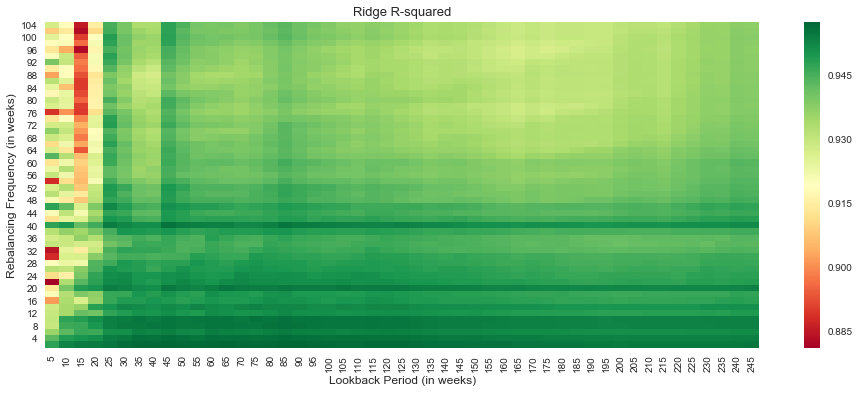

In [59]:
fig, ax = plt.subplots(figsize=(16,6))
sns.heatmap(r2_ridge.loc[:,:].sort_index(ascending=False), ax=ax, cmap='RdYlGn')
ax.set_title('Ridge R-squared', fontsize=13)
ax.set_xlabel("Lookback Period (in weeks)", fontsize=12)
ax.set_ylabel("Rebalancing Frequency (in weeks)", fontsize=12)

In [60]:
prices_lg = pd.read_csv(r"financial_data/bnp_data_long_term.csv", index_col=0, parse_dates=True, dayfirst=True)[['BNPIFEU',
                            'BNPIFUS', 'BNPIFJP', 'BNPIFCN', 'BNPIFFR', 'BNPIFGE', 'BNPIFGB', 'BNPIFCH', 'BNPIFKR',
                            'BNPIFUSC', 'BNPIFBR', 'BNPIFAU', 'BNPIFHK', 'BNPIFTW', 'BNPIFSG', 'BNPIFIT', 'BNPIFSP',
                            'BNPIFSW', 'BNPIFNE', 'BNPIFRU', 'BNPIFEM', 'BNPIFJT', 'BPFXEUR1', 'BPFXGBP1', 'BPFXCHF1',
                            'BPFXJPY1', 'BPFXAUD1', 'BPFXNZD1', 'BPFXNOK1', 'BPFXSEK1', 'BPFXCAD1', 'BPFXCZK1',
                            'BPFXPLN1', 'BPFXHUF1', 'BPFXTRY1', 'BPFXZAR1', 'BPFXSGD1', 'BPFXMXN1', 'BPFXINR1',
                            'BPFXKRW1', 'BPFXPHP1', 'BPFXTWD1', 'BPFXBRL1', 'BPFXCLP1', 'BPFXCOP1']]

returns_lg = prices_lg.resample("7D").first().pct_change().dropna()
prices_for_track_lg = prices_lg.iloc[-2570:].drop("BNPIFEU", axis=1)


lookback_list = range(5, 250, 5)
freq_list = range(2, 105, 2)

te_ridge_all = pd.DataFrame(index=freq_list)
r2_ridge_all = pd.DataFrame(index=freq_list)
correl_ridge_all = pd.DataFrame(index=freq_list)

for lookback in lookback_list:
    sx5e_lg = returns_lg[["BNPIFEU"]].iloc[-513-lookback:]
    bch_lg = returns_lg.drop("BNPIFEU", axis=1).iloc[-513-lookback:]
    
    for frequency in freq_list:
        
        df_weight_ridge = ridge_regression(sx5e_lg, bch_lg, lookback, frequency, l=1e-3)
        replication_ridge = make_track(prices_for_track_lg, df_weight_ridge)
        df_r['Ridge'] = replication_ridge
        
        returns_track = df_r.pct_change().dropna()
        corr = returns_track.corr(method="pearson")['BNPIFEU'].drop('BNPIFEU').iloc[0]
        feu = returns_track['BNPIFEU']
        returns_track = returns_track.drop('BNPIFEU', axis=1)
        
        te_ridge_all.loc[frequency, lookback] = (returns_track.T - feu.values).std(axis=1).iloc[0]
        r2_ridge_all.loc[frequency, lookback] = 1 - ((returns_track.T - feu.values).var(axis=1) / feu.values.var()).iloc[0]
        correl_ridge_all.loc[frequency, lookback] = corr
        
te_ridge_all = te_ridge_all.reindex_axis(sorted(te_ridge_all.columns), axis=1).sort_index(ascending=False)
r2_ridge_all = r2_ridge_all.reindex_axis(sorted(r2_ridge_all.columns), axis=1).sort_index(ascending=False)
correl_ridge_all = correl_ridge_all.reindex_axis(sorted(correl_ridge_all.columns), axis=1).sort_index(ascending=False)

c:\program files (x86)\python36-32\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
c:\program files (x86)\python36-32\lib\site-packages\ipykernel_launcher.py:40: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
c:\program files (x86)\python36-32\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.


Text(124,0.5,'Rebalancing Frequency (in weeks)')

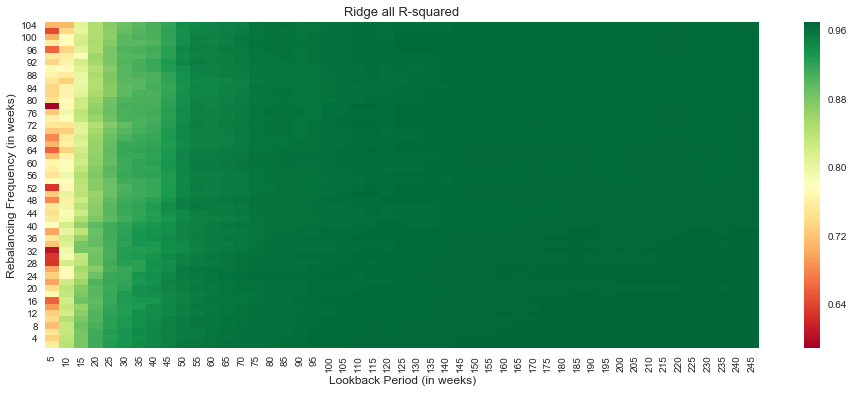

In [61]:
fig, ax = plt.subplots(figsize=(16,6))
sns.heatmap(r2_ridge_all.loc[:,:].sort_index(ascending=False), ax=ax, cmap='RdYlGn')
ax.set_title('Ridge all R-squared', fontsize=13)
ax.set_xlabel("Lookback Period (in weeks)", fontsize=12)
ax.set_ylabel("Rebalancing Frequency (in weeks)", fontsize=12)

In [62]:
df_l = prices.loc[replication.index][["BNPIFEU"]]

prices_lg = pd.read_csv(r"financial_data/bnp_data_long_term.csv", index_col=0, parse_dates=True, dayfirst=True)[['BNPIFEU',
                            'BNPIFUS', 'BNPIFJP', 'BNPIFCN', 'BNPIFFR', 'BNPIFGE', 'BNPIFGB', 'BNPIFCH', 'BNPIFKR',
                            'BNPIFUSC', 'BNPIFBR', 'BNPIFAU', 'BNPIFHK', 'BNPIFTW', 'BNPIFSG', 'BNPIFIT', 'BNPIFSP',
                            'BNPIFSW', 'BNPIFNE', 'BNPIFRU', 'BNPIFEM', 'BNPIFJT', 'BPFXEUR1', 'BPFXGBP1', 'BPFXCHF1',
                            'BPFXJPY1', 'BPFXAUD1', 'BPFXNZD1', 'BPFXNOK1', 'BPFXSEK1', 'BPFXCAD1', 'BPFXCZK1',
                            'BPFXPLN1', 'BPFXHUF1', 'BPFXTRY1', 'BPFXZAR1', 'BPFXSGD1', 'BPFXMXN1', 'BPFXINR1',
                            'BPFXKRW1', 'BPFXPHP1', 'BPFXTWD1', 'BPFXBRL1', 'BPFXCLP1', 'BPFXCOP1']]

returns_lg = prices_lg.resample("7D").first().pct_change().dropna()
prices_for_track_lg = prices_lg.iloc[-2570:].drop("BNPIFEU", axis=1)


lookback_list = range(5, 251, 5)
freq_list = range(2, 105, 2)

te_lasso_all = pd.DataFrame(index=freq_list)
r2_lasso_all = pd.DataFrame(index=freq_list)
correl_lasso_all = pd.DataFrame(index=freq_list)

for lookback in lookback_list:
    sx5e_lg = returns_lg[["BNPIFEU"]].iloc[-513-lookback:]
    bch_lg = returns_lg.drop("BNPIFEU", axis=1).iloc[-513-lookback:]
    
    for frequency in freq_list:
        
        df_weight_lasso = lasso_regression(sx5e_lg, bch_lg, lookback, frequency)
        replication_lasso = make_track(prices_for_track_lg, df_weight_lasso)
        df_l['Lasso'] = replication_lasso
        
        returns_track = df_l.pct_change().dropna()
        corr = returns_track.corr(method="pearson")['BNPIFEU'].drop('BNPIFEU').iloc[0]
        feu = returns_track['BNPIFEU']
        returns_track = returns_track.drop('BNPIFEU', axis=1)
        
        te_lasso_all.loc[frequency, lookback] = (returns_track.T - feu.values).std(axis=1).iloc[0]
        r2_lasso_all.loc[frequency, lookback] = 1 - ((returns_track.T - feu.values).var(axis=1) / feu.values.var()).iloc[0]
        correl_lasso_all.loc[frequency, lookback] = corr
        
te_lasso_all = te_lasso_all.reindex_axis(sorted(te_lasso_all.columns), axis=1).sort_index(ascending=False)
r2_lasso_all = r2_lasso_all.reindex_axis(sorted(r2_lasso_all.columns), axis=1).sort_index(ascending=False)
correl_lasso_all = correl_lasso_all.reindex_axis(sorted(correl_lasso_all.columns), axis=1).sort_index(ascending=False)

C:\Users\Rui Silva\Desktop\Projet OMA\Hedge-Fund-Replication\tools.py:126: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  las.fit(x, y)
c:\program files (x86)\python36-32\lib\site-packages\sklearn\linear_model\coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
c:\program files (x86)\python36-32\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\program files (x86)\python36-32\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
c:\program files (x86)\python36-32\lib\site-packages\ipykernel_launcher.py:42: FutureWarning

Text(124,0.5,'Rebalancing Frequency (in weeks)')

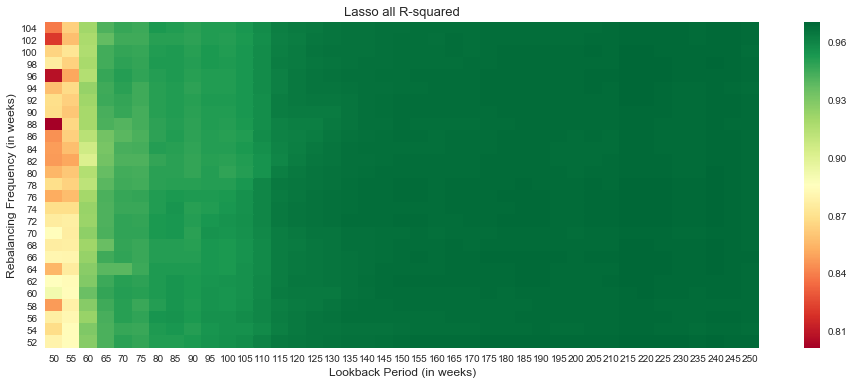

In [63]:
fig, ax = plt.subplots(figsize=(16,6))
sns.heatmap(r2_lasso_all.loc[:52,50:].sort_index(ascending=False), ax=ax, cmap='RdYlGn')
ax.set_title('Lasso all R-squared', fontsize=13)
ax.set_xlabel("Lookback Period (in weeks)", fontsize=12)
ax.set_ylabel("Rebalancing Frequency (in weeks)", fontsize=12)

In [64]:
df_l = prices.loc[replication.index][["BNPIFEU"]]

prices_lg = pd.read_csv(r"financial_data/bnp_data_long_term.csv", index_col=0, parse_dates=True, dayfirst=True)[['BNPIFEU',
                            'BNPIFFR', 'BNPIFGE', 'BNPIFIT', 'BNPIFSP']]

returns_lg = prices_lg.resample("7D").first().pct_change().dropna()
prices_for_track_lg = prices_lg.iloc[-2570:].drop("BNPIFEU", axis=1)


lookback_list = range(5, 251, 5)
freq_list = range(2, 105, 2)

te_lasso = pd.DataFrame(index=freq_list)
r2_lasso = pd.DataFrame(index=freq_list)
correl_lasso = pd.DataFrame(index=freq_list)

for lookback in lookback_list:
    sx5e_lg = returns_lg[["BNPIFEU"]].iloc[-513-lookback:]
    bch_lg = returns_lg.drop("BNPIFEU", axis=1).iloc[-513-lookback:]
    
    for frequency in freq_list:
        
        df_weight_lasso = lasso_regression(sx5e_lg, bch_lg, lookback, frequency)
        replication_lasso = make_track(prices_for_track_lg, df_weight_lasso)
        df_l['Lasso'] = replication_lasso
        
        returns_track = df_l.pct_change().dropna()
        corr = returns_track.corr(method="pearson")['BNPIFEU'].drop('BNPIFEU').iloc[0]
        feu = returns_track['BNPIFEU']
        returns_track = returns_track.drop('BNPIFEU', axis=1)
        
        te_lasso.loc[frequency, lookback] = (returns_track.T - feu.values).std(axis=1).iloc[0]
        r2_lasso.loc[frequency, lookback] = 1 - ((returns_track.T - feu.values).var(axis=1) / feu.values.var()).iloc[0]
        correl_lasso.loc[frequency, lookback] = corr
        
te_lasso = te_lasso.reindex_axis(sorted(te_lasso.columns), axis=1).sort_index(ascending=False)
r2_lasso = r2_lasso.reindex_axis(sorted(r2_lasso.columns), axis=1).sort_index(ascending=False)
correl_lasso = correl_lasso.reindex_axis(sorted(correl_lasso.columns), axis=1).sort_index(ascending=False)

C:\Users\Rui Silva\Desktop\Projet OMA\Hedge-Fund-Replication\tools.py:126: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  las.fit(x, y)
c:\program files (x86)\python36-32\lib\site-packages\sklearn\linear_model\coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
c:\program files (x86)\python36-32\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\program files (x86)\python36-32\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
c:\program files (x86)\python36-32\lib\site-packages\ipykernel_launcher.py:37: FutureWarning

Text(124,0.5,'Rebalancing Frequency (in weeks)')

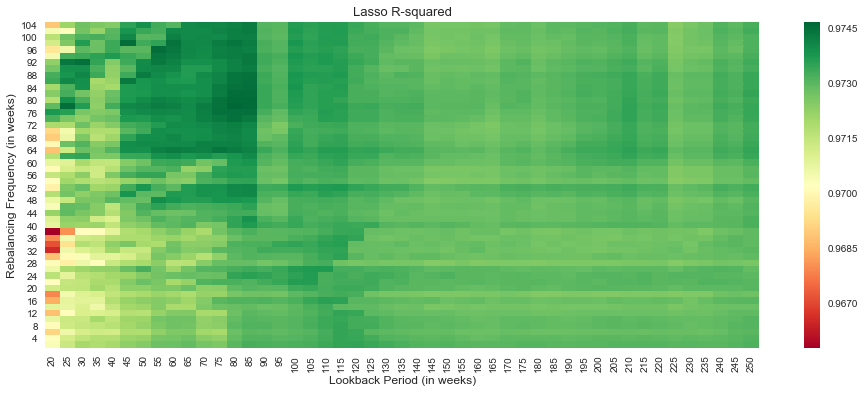

In [66]:
fig, ax = plt.subplots(figsize=(16,6))
sns.heatmap(r2_lasso.loc[:,20:].sort_index(ascending=False), ax=ax, cmap='RdYlGn')
ax.set_title('Lasso R-squared', fontsize=13)
ax.set_xlabel("Lookback Period (in weeks)", fontsize=12)
ax.set_ylabel("Rebalancing Frequency (in weeks)", fontsize=12)